In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import random


In [2]:

img_size = (128, 128)
batch_size = 32

train_ds_raw = tf.keras.utils.image_dataset_from_directory(
    "Oil_Spill_Dataset/train/train",                
    validation_split=0.2,     # 80% train, 20% val
    subset="training",
    seed=123,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True
)

val_ds_raw = tf.keras.utils.image_dataset_from_directory(
    "Oil_Spill_Dataset/train/train",
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True
)

class_names = train_ds_raw.class_names
print("Classes:", class_names)


Found 197 files belonging to 2 classes.
Using 158 files for training.
Found 197 files belonging to 2 classes.
Using 39 files for validation.
Classes: ['nospill', 'oilspill']


In [3]:
def check_balance(dataset, name):
    labels = []
    for _, y in dataset.unbatch():
        labels.append(y.numpy())
    label_counts = Counter(labels)
    print(f"\n{name} set distribution:")
    for i, c in enumerate(class_names):
        print(f"{c}: {label_counts[i]} samples")

check_balance(train_ds_raw, "Train")
check_balance(val_ds_raw, "Validation")



Train set distribution:
nospill: 81 samples
oilspill: 77 samples

Validation set distribution:
nospill: 17 samples
oilspill: 22 samples


In [4]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

normalization_layer = tf.keras.layers.Rescaling(1./255)

train_ds = train_ds_raw.map(lambda x, y: (normalization_layer(data_augmentation(x, training=True)), y))

val_ds = val_ds_raw.map(lambda x, y: (normalization_layer(x), y))

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


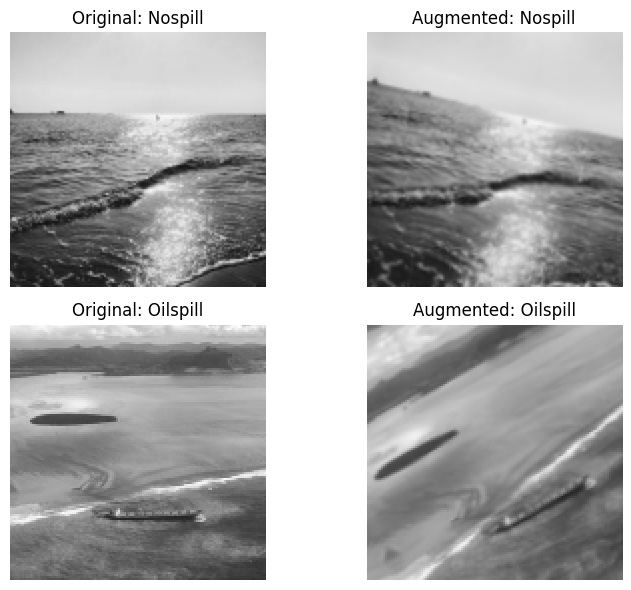

In [5]:
def show_spill_vs_nospill(dataset_raw, class_names, augmentation, normalization):
    found = False
    for images, labels in dataset_raw:   
        images = images.numpy()
        labels = labels.numpy()

        if (class_names.index("nospill") in labels) and (class_names.index("oilspill") in labels):
            found = True
            break   

    if not found:
        print("No batch contained both nospill and oilspill. Try larger batch_size.")
        return

    aug_images = augmentation(images, training=True).numpy()
    aug_images = normalization(aug_images).numpy()

    def to_display(img):
        img = np.clip(img / 255.0, 0, 1) if img.max() > 1 else np.clip(img, 0, 1)
        return img

    nospill_idx = np.random.choice(np.where(labels == class_names.index("nospill"))[0])
    oilspill_idx = np.random.choice(np.where(labels == class_names.index("oilspill"))[0])

    plt.figure(figsize=(8, 6))

    plt.subplot(2, 2, 1)
    plt.imshow(to_display(images[nospill_idx]))
    plt.title("Original: Nospill")
    plt.axis("off")

    plt.subplot(2, 2, 2)
    plt.imshow(to_display(aug_images[nospill_idx]))
    plt.title("Augmented: Nospill")
    plt.axis("off")

    # Oilspill
    plt.subplot(2, 2, 3)
    plt.imshow(to_display(images[oilspill_idx]))
    plt.title("Original: Oilspill")
    plt.axis("off")

    plt.subplot(2, 2, 4)
    plt.imshow(to_display(aug_images[oilspill_idx]))
    plt.title("Augmented: Oilspill")
    plt.axis("off")

    plt.tight_layout()
    plt.show()
show_spill_vs_nospill(train_ds_raw, class_names, data_augmentation, normalization_layer)
